In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import seaborn as sns
from PIL import Image, ImageOps
import cv2
from pathlib import Path

In [2]:
from google.colab import files

files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
dataset_name = 'jangedoo/utkface-new'
zip_name = dataset_name.split('/')[-1]

!kaggle datasets download -d {dataset_name}
!unzip -q ./{zip_name}.zip -d ~/Dataset

 99% 329M/331M [00:05<00:00, 20.2MB/s]
100% 331M/331M [00:05<00:00, 68.6MB/s]


In [4]:
! unzip utkface-new.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_0_20170109004755204.jpg.chip.jpg  
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_0_20170111182452832.jpg.chip.jpg  
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_1_20170103230340961.jpg.chip.jpg  
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_1_20170104011329697.jpg.chip.jpg  
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_1_20170104165020320.jpg.chip.jpg  
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_1_20170108230211421.jpg.chip.jpg  
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_2_20170104022134829.jpg.chip.jpg  
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_2_20170104023010725.jpg.chip.jpg  
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_2_20170104172537171.jpg.chip.jpg  
  inflating: data/utkface_aligned_cropped/crop_part1/34_1_2_20170104201443273.jpg.chip.jpg  
  inflating: data/u

In [6]:
path = Path("/content/data/UTKFace")
filenames = list(map(lambda x: x.name, path.glob('*.jpg')))

In [7]:
age, gender, images = [], [], []
for filename in filenames:
    images.append(filename)
    temp = filename.split('_')
    age.append(temp[0])
    gender.append(temp[1])

In [8]:
len(filenames)

23708

In [11]:
data = pd.DataFrame()
data['image'], data['age'], data['gender'] = images, age, gender

In [12]:
genderclass = {0:"Male",1:"Female"}
data = data.astype({'age':'float32', 'gender': 'int32'})

In [13]:
data

,image,age,gender
0,50_0_0_20170120133257846.jpg.chip.jpg,50.0,0
1,24_1_3_20170104222359247.jpg.chip.jpg,24.0,1
2,1_0_4_20161221195316815.jpg.chip.jpg,1.0,0
3,26_1_3_20170104235406507.jpg.chip.jpg,26.0,1
4,59_0_3_20170109132518583.jpg.chip.jpg,59.0,0
...,...,...,...
23703,46_0_0_20170104205749003.jpg.chip.jpg,46.0,0
23704,28_1_1_20170116234825295.jpg.chip.jpg,28.0,1
23705,90_0_0_20170117175429276.jpg.chip.jpg,90.0,0
23706,26_1_1_20170117173603334.jpg.chip.jpg,26.0,1


In [14]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [15]:
from tensorflow.keras.preprocessing.image import load_img
xtrain = []
for file in train.image:
    img = load_img("/content/data/UTKFace/"+file, grayscale=True)
    img = img.resize((128,128), Image.ANTIALIAS)
    img = np.array(img)
    xtrain.append(img)

xtrain = np.array(xtrain)

xtrain = xtrain.reshape(len(xtrain), 128,128,1)

/usr/local/lib/python3.10/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(
<ipython-input-15-4962cd381e56>:5: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((128,128), Image.ANTIALIAS)


In [16]:
xtrain.shape

(18966, 128, 128, 1)

In [17]:
xtrain = xtrain/255
ygender = np.array(train.gender)
yage = np.array(train.age)

In [18]:
input_size = (128,128,1)

In [19]:
xtrain

array([[[[0.17254902],
         [0.16078431],
         [0.15686275],
         ...,
         [0.09803922],
         [0.09803922],
         [0.10980392]],

        [[0.16470588],
         [0.15686275],
         [0.15294118],
         ...,
         [0.09803922],
         [0.10588235],
         [0.11764706]],

        [[0.15294118],
         [0.14117647],
         [0.14117647],
         ...,
         [0.09803922],
         [0.10980392],
         [0.1254902 ]],

        ...,

        [[0.11372549],
         [0.11764706],
         [0.12941176],
         ...,
         [0.05098039],
         [0.07843137],
         [0.10196078]],

        [[0.10980392],
         [0.11764706],
         [0.1254902 ],
         ...,
         [0.05098039],
         [0.07843137],
         [0.10196078]],

        [[0.10980392],
         [0.11372549],
         [0.1254902 ],
         ...,
         [0.04705882],
         [0.0745098 ],
         [0.09803922]]],


       [[[0.42352941],
         [0.5372549 ],
         [0.63

##Using Sequential API

In [64]:
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant, identity
from tensorflow.keras.layers import Dropout, Input, Add, Dense, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model

inputs = Input((input_size))
X = Conv2D(64, (3, 3), activation='relu')(inputs)
X = BatchNormalization(axis = 3)(X)
X = MaxPooling2D((3, 3))(X)

X = Conv2D(128, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

X = Conv2D(256, (3, 3), activation='relu')(X)
X = MaxPooling2D((2, 2))(X)

X = Flatten()(X)

dense_1 = Dense(256, activation='relu')(X)
dense_2 = Dense(256, activation='relu' )(X)
dense_3 = Dense(128, activation='relu' )(dense_2)
dropout_1 = Dropout(0.4)(dense_1)
dropout_2 = Dropout(0.4)(dense_3)
output_1 = Dense(1,activation='sigmoid', name='gender_output')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_output')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1,output_2])

In [73]:
model.compile(loss=['binary_crossentropy','mae'],optimizer="Adam",metrics=["accuracy"])
history = model.fit(x=xtrain, y=[ygender, yage], batch_size = 10, epochs=2, validation_split= 0.1)

Epoch 1/2
1707/1707 [==============================] - 28s 14ms/step - loss: 11.8224 - gender_output_loss: 0.3943 - age_output_loss: 11.4282 - gender_output_accuracy: 0.8194 - age_output_accuracy: 0.0349 - val_loss: 10.1173 - val_gender_output_loss: 0.4158 - val_age_output_loss: 9.7014 - val_gender_output_accuracy: 0.7955 - val_age_output_accuracy: 0.0564
Epoch 2/2
1707/1707 [==============================] - 24s 14ms/step - loss: 9.6668 - gender_output_loss: 0.3666 - age_output_loss: 9.3002 - gender_output_accuracy: 0.8355 - age_output_accuracy: 0.0456 - val_loss: 11.4054 - val_gender_output_loss: 0.4128 - val_age_output_loss: 10.9926 - val_gender_output_accuracy: 0.8050 - val_age_output_accuracy: 0.0564


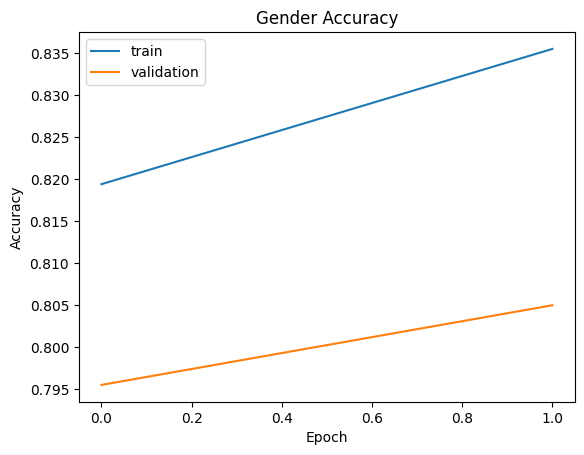

In [74]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('Gender Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

##Using Sequential CLass

##1.Gender

In [27]:
model1=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="relu")


])


model1.compile(loss="binary_crossentropy",optimizer="Adam",metrics=["accuracy"])
history=model1.fit(xtrain,ygender, epochs=5, shuffle=True, )

Epoch 1/5
593/593 [==============================] - 13s 17ms/step - loss: 0.7123 - accuracy: 0.6998
Epoch 2/5
593/593 [==============================] - 10s 17ms/step - loss: 0.6735 - accuracy: 0.6532
Epoch 3/5
593/593 [==============================] - 10s 17ms/step - loss: 0.6368 - accuracy: 0.6702
Epoch 4/5
593/593 [==============================] - 10s 17ms/step - loss: 0.7278 - accuracy: 0.5848
Epoch 5/5
593/593 [==============================] - 10s 16ms/step - loss: 0.6135 - accuracy: 0.6701


## 2. Age

In [24]:
model2=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128,(3,3),activation="relu"),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(256,activation="relu"),
    tf.keras.layers.Dense(128,activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1,activation="relu")


])


model2.compile(loss="mse",optimizer="Adam",metrics=["accuracy"])
history2=model2.fit(xtrain,yage, epochs=5, shuffle=True, )

Epoch 1/5
593/593 [==============================] - 13s 17ms/step - loss: 323.9283 - accuracy: 0.0451
Epoch 2/5
593/593 [==============================] - 11s 18ms/step - loss: 183.3186 - accuracy: 0.0179
Epoch 3/5
593/593 [==============================] - 11s 18ms/step - loss: 143.5728 - accuracy: 0.0088
Epoch 4/5
593/593 [==============================] - 10s 17ms/step - loss: 127.4554 - accuracy: 0.0095
Epoch 5/5
593/593 [==============================] - 10s 17ms/step - loss: 116.7530 - accuracy: 0.0165


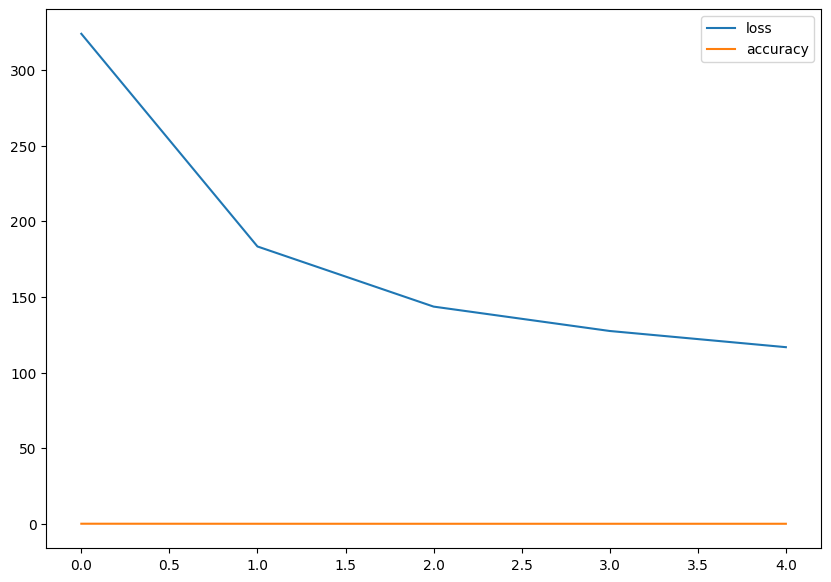

In [26]:
pd.DataFrame(history2.history).plot(figsize=(10, 7));


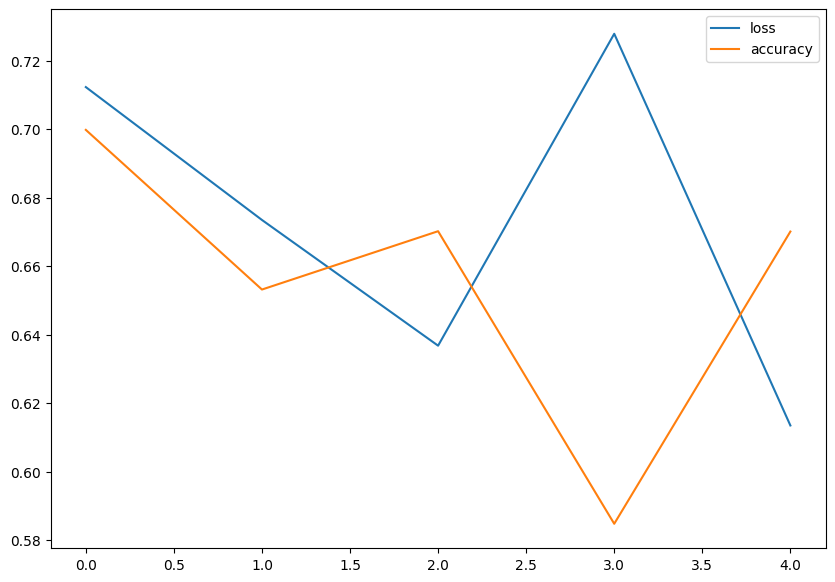

In [28]:
pd.DataFrame(history.history).plot(figsize=(10, 7));


In [ ]:
index=1000
print("Original: Gender = ", genderclass[ygender[index]]," Age = ", yage[index])

pred = model.predict(xtrain[index].reshape(1, 128, 128, 1))
pred_gender = genderclass[pred]
pred_age = round(pred[1][0][0])

print("Prediction: Gender = ", pred_gender," Age = ", pred_age)
plt.imshow(xtrain[index].reshape(128,128), cmap='gray')

In [34]:
def load_and_prep_image(filename, img_shape=128):
  # Read in target file (an image)
  img = tf.io.read_file(filename)

  # Decode the read file into a tensor & ensure 3 colour channels
  # (our model is trained on images with 3 colour channels and sometimes images have 4 colour channels)
  img = tf.image.decode_image(img, channels=3)

  # Resize the image (to the same size our model was trained on)
  img = tf.image.resize(img, size = (128,128))

  # Rescale the image (get all values between 0 and 1)
  img = img/255.
  return img

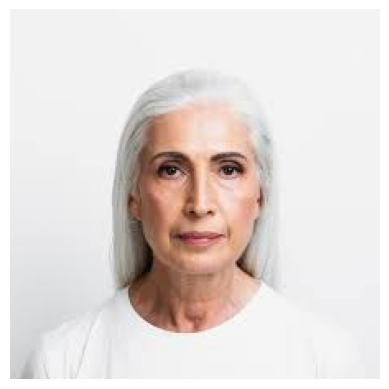

In [35]:
import matplotlib.image as mpimg
face = mpimg.imread("/content/download.jpg")
plt.imshow(face)
plt.axis(False);

In [38]:
facetest=load_and_prep_image("/content/download.jpg")

In [39]:
facetest

<tf.Tensor: shape=(128, 128, 3), dtype=float32, numpy=
array([[[0.94509804, 0.94509804, 0.94509804],
        [0.94509804, 0.94509804, 0.94509804],
        [0.94509804, 0.94509804, 0.94509804],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       [[0.94509804, 0.94509804, 0.94509804],
        [0.94509804, 0.94509804, 0.94509804],
        [0.94509804, 0.94509804, 0.94509804],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       [[0.94509804, 0.94509804, 0.94509804],
        [0.94509804, 0.94509804, 0.94509804],
        [0.94509804, 0.94509804, 0.94509804],
        ...,
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ],
        [0.9490196 , 0.9490196 , 0.9490196 ]],

       ...,

       [[0.79522884, 0.8109151 , 0.8148367 ],
        [0.78

In [42]:
face = tf.expand_dims(facetest, axis=0)

In [ ]:
model.predict(face)